# Experiment 7: MLP network using custom trained Word2Vec embeddings

Lets build on our last experiment with fully connected feedforward networks (MLP) by instead training it on the Word2Vec word embeddings we created using gensim in the word_embeddings notebook in the parent directory.
To do this, we first load in our data and our embedding vector model, and create a new network architecture to accept this pre-trained model as the first layer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from notebooks import word_normalization as wn
from keras.preprocessing import text
from exp4_data_feature_extraction import get_balanced_dataset
import gensim

Using TensorFlow backend.


Our word embedding vector is over the entire dataset, but we only want a subset of this data. Let's use 20,000 reviews from our dataset.

In [2]:
all_reviews, fake_reviews, genuine_reviews, unused_genuine_reviews = get_balanced_dataset()
review_subset = all_reviews[:50000]

X = [x.review_content for x in review_subset]
y = np.array([x.label for x in review_subset])

Now we load our gensim embedding model in and create an embedding matrix of our reviews on it.

In [5]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load('../../wordvec/yelp_w2v.kv', mmap='r')

In [6]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

X_sequences = np.array(tokenizer.texts_to_sequences(X))

print(vocab_size)

58758


In [13]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word_vectors.wv.vocab:
        vector = word_vectors.wv[word]
    if vector is not None: 
        embedding_matrix[i] = np.array(vector, dtype=np.float32)
        
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements/vocab_size)
print(embedding_matrix.shape)

0.9999829810408796
(58758, 100)


In [24]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [19]:
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import regularizers

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
maxlen = 512

X_train, X_test, y_train, y_test = train_test_split(X_sequences, y)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Because our word embeddings have already been trained, we don't need to train the layer.

In [29]:
model_no_embed_train = keras.Sequential([
keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
keras.layers.GlobalMaxPool1D(),
keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)),
keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model_no_embed_train.summary()
model_no_embed_train.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_noembedtrain = model_no_embed_train.fit(X_train, y_train, 
          epochs=50, 
          batch_size=256, 
          validation_split=0.3, 
          verbose=1,
          callbacks=[early_stop])

scores = model_no_embed_train.evaluate(X_test, y_test, verbose=1)
print(model_no_embed_train.metrics_names, scores)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 512, 100)          5875800   
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 5,879,065
Trainable params: 3,265
Non-trainable params: 5,875,800
_________________________________________________________________
Train on 26250 samples, validate on 11250 samples
Epoch 1/50
26250/26250 [==============================] - 7s 263us/step - loss: 0.9855 - acc: 0.5449 - val_loss: 0.8418 - val_acc: 0.5879
Epoch 2/50
26250/26250 [==============================] - 5s 183us/step 

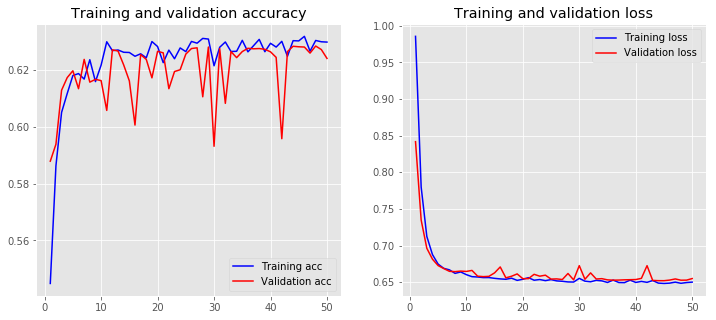

In [30]:
plot_history(history_noembedtrain)

In [ ]:
model_embed_train = keras.Sequential([
keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True),
keras.layers.GlobalMaxPool1D(),
keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)),
keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model_embed_train.summary()
model_embed_train.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history_embedtrain = model_embed_train.fit(X_train, y_train, 
          epochs=50,
          batch_size=1024, 
          validation_split=0.3, 
          verbose=1,
          callbacks=[early_stop])
scores = model_embed_train.evaluate(X_test, y_test, verbose=1)
print(model_embed_train.metrics_names, scores)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 512, 100)          5875800   
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 5,879,065
Trainable params: 5,879,065
Non-trainable params: 0
_________________________________________________________________
Train on 26250 samples, validate on 11250 samples
Epoch 1/50
26250/26250 [==============================] - 153s 6ms/step - loss: 1.1493 - acc: 0.5097 - val_loss: 1.0817 - val_acc: 0.5210
Epoch 2/50
26250/26250 [==============================] - 137s 5ms/step - lo

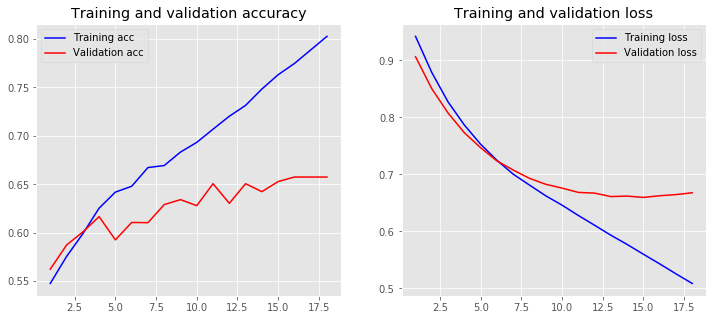

In [62]:
plot_history(history_embedtrain)